## Example 11 - Making a basic vessel class

In [9]:
# package(s) related to time, space and id
import datetime
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# Used for making the graph to visualize our problem
import networkx as nx  

# tranport network analysis package
import transport_network_analysis.core as core
# import digital_twin.model as model

## Create vessel
The Transport Network Analysis core defines several classes which can be combined in mixin classes you can define yourself. For example, in this simulation we define a Vessel as a TransportResource (so it mainly should be able to move and carry some payload):
* Identifiable: an object that can be identified with a name 
* Log: an object which will contain a log of events that took place concerning this object after the simulation is complete 
* ContainerDependentMovable: this is in fact a combination (extension) of two other core classes:
    * HasContainer: an object which contains a storage for materials
    * Movable: an object which can move from one geographical location to another (extends Locatable, clearly a moving object must keep track of its current location)
* HasResource: an object only a limited number of activities can interact with at the same time

In [10]:
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, core.Routeable,
                          core.HasResource), {})

In [11]:
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

data_vessel = {"env": [],
               "name": "Transport barge 01",
               "geometry": shapely.geometry.Point(5.019298185633251, 52.94239823421129),  # lon, lat
               "route": [],
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1.6, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

In [ ]:
def start(env, vessel):
    for vertice in vessel.path:
        yield from vessel.move(vertice)
        
        if vessel.location == vessel.destination:
            break

## Create graph

In [19]:
# initialise graph object
G = nx.Graph()

In [20]:
# sketch of example graph
#
#  1:       o--o
#          /    \
#  0:  o--o      o--o
#          \    /
# -1:       o--o
#
#      1  2 3  4 5  6

color_map = []
# define and add nodes
G.add_node("a", pos=(1, 0)); color_map.append('r')
G.add_node("b", pos=(2, 0)); color_map.append('r')
G.add_node("c", pos=(3, -1)); color_map.append('r')
G.add_node("d", pos=(3, 1)); color_map.append('r')
G.add_node("e", pos=(4, -1)) ;color_map.append('r')
G.add_node("f", pos=(4, 1)); color_map.append('r')
G.add_node("g", pos=(5, 0)); color_map.append('r')
G.add_node("h", pos=(6, 0));  color_map.append('r')

In [21]:
# define wheighted edges (from, to, weight)
e = [("a", "b", 1), 
    ("b", "c", 1), 
    ("b", "d", 2), 
    ("c", "e", 5), 
    ("d", "f", 2), 
    ("e", "g", 1), 
    ("f", "g", 2), 
    ("g", "h", 1)]

# add weighted edges
G.add_weighted_edges_from(e)

In [23]:
labels = nx.get_edge_attributes(G,'weight')
print(labels)

{('a', 'b'): 1, ('b', 'c'): 1, ('b', 'd'): 2, ('c', 'e'): 5, ('d', 'f'): 2, ('e', 'g'): 1, ('f', 'g'): 2, ('g', 'h'): 1}


{'a': Text(1,0,'a'),
 'b': Text(2,0,'b'),
 'c': Text(3,-1,'c'),
 'd': Text(3,1,'d'),
 'e': Text(4,-1,'e'),
 'f': Text(4,1,'f'),
 'g': Text(5,0,'g'),
 'h': Text(6,0,'h')}

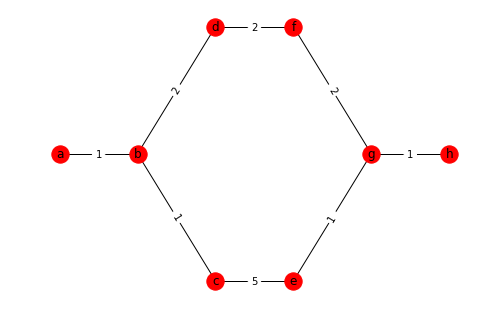

In [24]:
nx.draw(G,nx.get_node_attributes(G, 'pos'))
nx.draw_networkx_edge_labels(G,nx.get_node_attributes(G, 'pos'),edge_labels=labels)
nx.draw_networkx_labels(G,nx.get_node_attributes(G, 'pos'))

## Generate Dijkstra Path and add it to vessel

In [26]:
path = nx.dijkstra_path(G, "a", "h", weight='weight')
print(path)

['a', 'b', 'd', 'f', 'g', 'h']


In [27]:
vessel.route = path

In [28]:
vessel.__dict__

{'compute_v': <function __main__.compute_v_provider.<locals>.<lambda>>,
 'container': <simpy.resources.container.Container at 0x1fdda1ea908>,
 'env': [],
 'geometry': <shapely.geometry.point.Point at 0x1fdda1ea860>,
 'geometry_log': [('a', 'b'), ('a', 'b')],
 'id': 'bfb7955c-0f5b-11e9-8aec-60f677ba2ce0',
 'log': ['start sailing', 'stop sailing'],
 'name': 'Transport barge 01',
 'resource': <simpy.resources.resource.Resource at 0x1fdda1ea7f0>,
 'route': ['a', 'b', 'd', 'f', 'g', 'h'],
 't': [1, 2],
 'total_requested': 0,
 'v': 1,
 'value': [3, 3],
 'wgs84': <pyproj.Geod at 0x1fdd9d2cd30>}

## Run simulation

In [ ]:
env = simpy.Environment()



env.process(start(env, vessel))

env.run()